In [1]:
!pip install nltk
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [3]:
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk import word_tokenize
from wordcloud import WordCloud

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [82]:
with open('drive/MyDrive/Diplom/test.csv') as f:
    test = pd.read_csv(f,sep='\t')
with open('drive/MyDrive/Diplom/train.csv') as f:
    train = pd.read_csv(f,sep='\t')

In [6]:
ds = pd.concat([train,test], ignore_index=True) 

# Визуализация текста

 Частота количества слов в комментариях.

<Axes: ylabel='Frequency'>

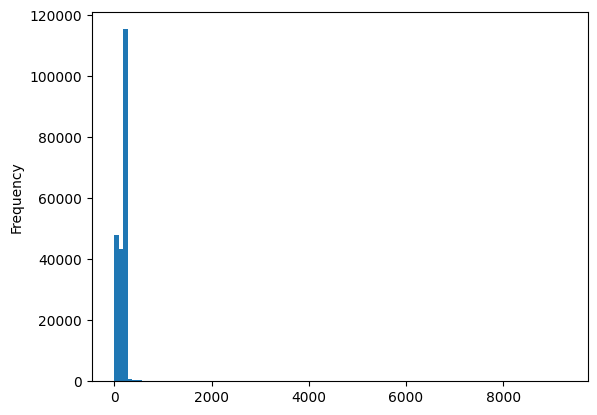

In [7]:
ds['body_length'].plot(kind='hist', bins = 100)

In [8]:
print('Average', ds['body_length'].mean())
print('Max', ds['body_length'].max())
print('Min', ds['body_length'].min())

Average 181.64365524084343
Max 9280
Min 1


В среднем 181 слово в комментарии.

Для визуализации комментариев используется прием - wordcloud. Это картинка со словами, в которой размер слова, связан с частотой встречаемости его в тексте. Чем больше частота, тем крупнее слово и наоборот. Используя этот прием, можно проанализировать состав комментариев и определить слова, которые часто повторяются, но не дают никакого понимания о классе комментария. 


In [9]:
word_cloud_cloud = ''.join(ds['body'])

<function matplotlib.pyplot.show(close=None, block=None)>

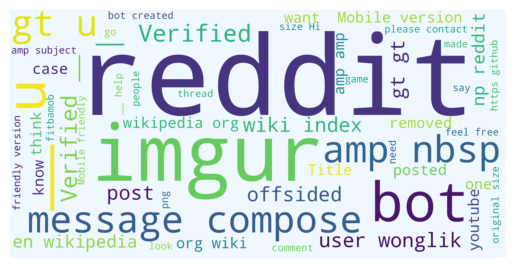

In [10]:
picture = WordCloud(max_words = 50,
                    background_color = 'aliceblue',
                    scale = 10).generate(word_cloud_cloud)
plt.figure
plt.imshow(picture, interpolation = 'bilinear')
plt.axis('off')
plt.show

Можно видеть, что в тексте у нас присутствуют символы ('gt') из html кода старницы, есть аббревиатуры расширеший ('png'), сокращения ('org', 'en', 'u') и слова без эмоциональной окраски или оценки ('Hi', 'know', 'go') и т.д. Самыми крупными словами здесь являются: 'reddit' - сервис-источник комментариев, 'imgur' - сайт, где делятся изображениями, 'bot' - программа выполняющая заданные действия.

# NLP

1. Перевод текста в нижний регистр
2. Удаление особых символов
3. Удаление стоп-слов и слишком часто/редко встречающихся слов
4. Стемминг/лемматизация

In [83]:
train['body_new'] = train['body'].str.lower()
test['body_new'] = test['body'].str.lower()

In [84]:
def delt(x):
    return re.sub(r'[^A-Za-z ]+', " ", x)


train['body_new'] = train['body_new'].apply(lambda x: delt(x))
test['body_new'] = test['body_new'].apply(lambda x: delt(x))

In [85]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [86]:
stop_words = stopwords.words('english')
stop_words.extend(['com', 'r', 'u', 'k', 'gt', 'www', 'png', 'comment','post', 'amp','nbsp', 'xkcd', 'np',
       'tag', 'http np', 'watch', 'people', 'see','thing', 'look', 'v'])

In [87]:
from nltk.tokenize import sent_tokenize, word_tokenize

stop = set(stop_words)

wordnet_lemmatizer = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    normalized = " ".join(wordnet_lemmatizer.lemmatize(word) for word in stop_free.split())
    return normalized

train['body_new'] = train['body_new'].apply(lambda x: clean(x))
test['body_new'] = test['body_new'].apply(lambda x: clean(x))

TF-IDF

Для элемента i в комментарии j : $w_{i,j} = tf_{i,j}×log(\frac{N}{df_{i}})$ , $tf_{i,j}$ - количество появлений i в j, $df_{i}$ - количество комментариев, содержащих i, N - общее количество комментариев.

In [88]:
tfidf_counts_NLTK = TfidfVectorizer(
                               ngram_range=(1,2),
                               max_df=10000, #max_df = 25 means "ignore terms that appear in more than 25 documents".
                               min_df=100, #min_df = 5 means "ignore terms that appear in less than 5 documents".
                               max_features=100)

train_tfidf = tfidf_counts_NLTK.fit_transform(train['body_new'])
test_tfidf = tfidf_counts_NLTK.transform(test['body_new'])
print(f"n_samples: {train_tfidf.shape[0]}, n_features: {train_tfidf.shape[1]}")
print(f"n_samples: {test_tfidf.shape[0]}, n_features: {test_tfidf.shape[1]}")

n_samples: 140037, n_features: 100
n_samples: 68584, n_features: 100


In [89]:
importance = np.argsort(np.asarray(train_tfidf.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf_counts_NLTK.get_feature_names_out())
tfidf_feature_names[importance[:10]]

array(['title', 'original', 'like', 'subreddit', 'verified', 'image',
       'message', 'user', 'one', 'video'], dtype=object)

In [90]:
train2 = pd.DataFrame(train_tfidf.todense(), columns = tfidf_feature_names) 
test2 = pd.DataFrame(test_tfidf.todense(), columns = tfidf_feature_names) 

In [91]:
train = pd.concat([train, train2], axis = 1)
test = pd.concat([test, test2], axis = 1)

# TextBlob

In [92]:
from textblob import TextBlob

In [93]:
train['polarity'] = train['body_new'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity'] = test['body_new'].apply(lambda x: TextBlob(x).sentiment.polarity)
train['subjectivity'] = train['body_new'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity'] = test['body_new'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# LogReg

In [94]:
train = train.drop(columns = ['Unnamed: 0'])
test = test.drop(columns = ['Unnamed: 0'])

In [95]:
X_train = train.drop(columns = ['Y','body','body_new'])
X_test = test.drop(columns = ['Y', 'body','body_new'])
y_train = train.Y
y_test = test.Y

In [101]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def metrics(y_test, y_pred, y_pred_proba):
  
  conf = confusion_matrix(y_test, y_pred)
  print(conf)
  f1_ma = round(f1_score(y_test, y_pred, average='macro'), 4)
  f1_mi = round(f1_score(y_test, y_pred, average='micro'), 4)
  f1_we = round(f1_score(y_test, y_pred, average='weighted'), 4)
  b_acc = round(balanced_accuracy_score(y_test, y_pred), 4)
  neg_ll = round(- log_loss(y_test, y_pred_proba), 4)
  roc_auc_ovr = round(roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class = 'ovr'), 4)
  roc_auc_ovo = round(roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class = 'ovo'), 4)

  print('f1_score_macro:', f1_ma)
  print('f1_score_micro:', f1_mi)
  print('f1_score_weighted:', f1_we)
  print('balanced_accuracy_score:', b_acc)
  print('neg_log_loss:', neg_ll)
  print('roc_auc_score ovr:', roc_auc_ovr)
  print('roc_auc_score ovo:', roc_auc_ovo)

  return pd.DataFrame({'features': ['+TF-IDF+pol_and_sub'],'f1_score_macro': [f1_ma], 'f1_score_micro': [f1_mi],'f1_score_weighted': [f1_we], 'balanced_accuracy_score': [b_acc], 'neg_log_loss': [neg_ll],'roc_auc_score ovr': [roc_auc_ovr], 'roc_auc_score ovo': [roc_auc_ovo]})


In [102]:
pipel = Pipeline(steps = [('scaler', StandardScaler()), ('model',LogisticRegression(max_iter=10000, class_weight = 'balanced'))])

pipel.fit(X_train, y_train)

y_pred = pipel.predict(X_test)
y_pred_proba = pipel.predict_proba(X_test)

res = metrics(y_test, y_pred, y_pred_proba)

[[42435  9180  1545]
 [  160  1582   250]
 [ 2757  6017  4658]]
f1_score_macro: 0.4995
f1_score_micro: 0.7097
f1_score_weighted: 0.7644
balanced_accuracy_score: 0.6464
neg_log_loss: -0.7828
roc_auc_score ovr: 0.8496
roc_auc_score ovo: 0.8473


# Сохраниение


In [99]:
with open('drive/MyDrive/Diplom/results.csv') as f:
    results = pd.read_csv(f)

In [105]:
results = pd.concat([results, res])

In [107]:
results.drop(columns = ['Unnamed: 0'], inplace = True)

In [108]:
results

,features,f1_score_macro,f1_score_micro,f1_score_weighted,balanced_accuracy_score,neg_log_loss,roc_auc_score ovr,roc_auc_score ovo
0,"ups,score,body_length",0.4324,0.6345,0.7000,0.5846,-1.0150,0.7410,0.7540
0,+TF-IDF+pol_and_sub,0.4995,0.7097,0.7644,0.6464,-0.7828,0.8496,0.8473


In [109]:
train.to_csv('drive/MyDrive/Diplom/train2.csv', sep='\t')
test.to_csv('drive/MyDrive/Diplom/test2.csv', sep='\t')
results.to_csv('drive/MyDrive/Diplom/results.csv')